<a href="https://colab.research.google.com/github/snehasamanta/Dog-vs-Cat-classification/blob/main/dog_vs_cat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unzip the data file

In [ ]:
!unzip "/content/drive/MyDrive/datasets/dogs-vs-cats.zip"
 

Archive:  /content/drive/MyDrive/datasets/dogs-vs-cats.zip
  inflating: sampleSubmission.csv    
  inflating: test1.zip               
  inflating: train.zip               


# Unzip the train and test dataset

In [ ]:
!unzip "/content/drive/MyDrive/datasets/train.zip"
!unzip "/content/drive/MyDrive/datasets/test1.zip"

Streaming output truncated to the last 5000 lines.
  inflating: test1/5499.jpg          
  inflating: test1/55.jpg            
  inflating: test1/550.jpg           
  inflating: test1/5500.jpg          
  inflating: test1/5501.jpg          
  inflating: test1/5502.jpg          
  inflating: test1/5503.jpg          
  inflating: test1/5504.jpg          
  inflating: test1/5505.jpg          
  inflating: test1/5506.jpg          
  inflating: test1/5507.jpg          
  inflating: test1/5508.jpg          
  inflating: test1/5509.jpg          
  inflating: test1/551.jpg           
  inflating: test1/5510.jpg          
  inflating: test1/5511.jpg          
  inflating: test1/5512.jpg          
  inflating: test1/5513.jpg          
  inflating: test1/5514.jpg          
  inflating: test1/5515.jpg          
  inflating: test1/5516.jpg          
  inflating: test1/5517.jpg          
  inflating: test1/5518.jpg          
  inflating: test1/5519.jpg          
  inflating: test1/552.jpg           

In [ ]:
import pandas as pd
submission=pd.read_csv("/content/drive/MyDrive/datasets/sampleSubmission.csv")
submission.head()

,id,label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [5]:
test_images_dir = "/content/drive/MyDrive/datasets/test1"
train_images_dir= "/content/drive/MyDrive/datasets/train"
list_images_path = os.listdir(train_images_dir)

In [6]:
labels = []
for image_path in list_images_path:
    if "cat" in image_path:
        labels.append('cat')
    else:
        labels.append('dog')

df = pd.DataFrame({"file":list_images_path, "label":labels})

print(df.head())
print(df.tail())

           file label
0     cat.0.jpg   cat
1     cat.1.jpg   cat
2    cat.10.jpg   cat
3   cat.100.jpg   cat
4  cat.1000.jpg   cat
               file label
24995  dog.9995.jpg   dog
24996  dog.9996.jpg   dog
24997  dog.9997.jpg   dog
24998  dog.9998.jpg   dog
24999  dog.9999.jpg   dog


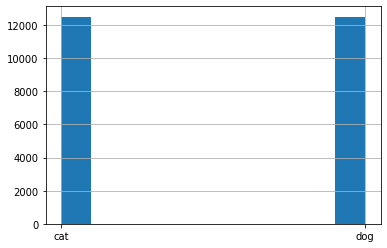

In [7]:
df['label'].hist()

In [10]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

(-0.5, 499.5, 373.5, -0.5)

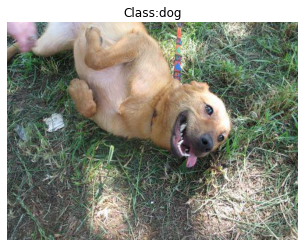

In [19]:
sample = np.random.randint(len(df))

img_path = train_images_dir +"/"+ df['file'][sample]
label    = df['label'][sample]

img = Image.open(img_path)

plt.imshow(img)
plt.title(f"Class:{label}")
plt.axis('off')

In [20]:
df.shape

(25000, 2)

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
train_df, valid_df = train_test_split(df, test_size = 0.15)

In [23]:
print("Train set:", train_df.shape)
print("Validation set:", valid_df.shape)

Train set: (21250, 2)
Validation set: (3750, 2)


In [24]:
train_df.head()

,file,label
10877,cat.8538.jpg,cat
412,cat.10368.jpg,cat
21649,dog.6983.jpg,dog
11677,cat.9258.jpg,cat
7385,cat.5395.jpg,cat


In [25]:
valid_df.head()

,file,label
22784,dog.8003.jpg,dog
6543,cat.4637.jpg,cat
5430,cat.3635.jpg,cat
24564,dog.9606.jpg,dog
10778,cat.8449.jpg,cat


# Data augmentation

In [27]:
from keras.preprocessing.image import ImageDataGenerator

In [28]:
train_gen = ImageDataGenerator(rescale = 1.0/255.0,
                               horizontal_flip = True,
                               vertical_flip   = True,
                               fill_mode = 'nearest',
                               rotation_range = 10,
                               width_shift_range = 0.2,
                               height_shift_range= 0.2,
                               shear_range= 0.15,
                               brightness_range= (.5,1.2),
                               zoom_range = 0.2)

In [30]:
IMAGE_SIZE = 128
BATCH_SIZE = 32

In [31]:
train_gen = train_gen.flow_from_dataframe(train_df,
                                          directory = train_images_dir,
                                          x_col = 'file', 
                                          y_col = 'label', 
                                          target_size =(IMAGE_SIZE, IMAGE_SIZE), 
                                          class_mode = 'categorical',
                                          batch_size = BATCH_SIZE, 
                                          color_mode = 'rgb', 
                                          shuffle = True)

Found 21250 validated image filenames belonging to 2 classes.


(32, 128, 128, 3)


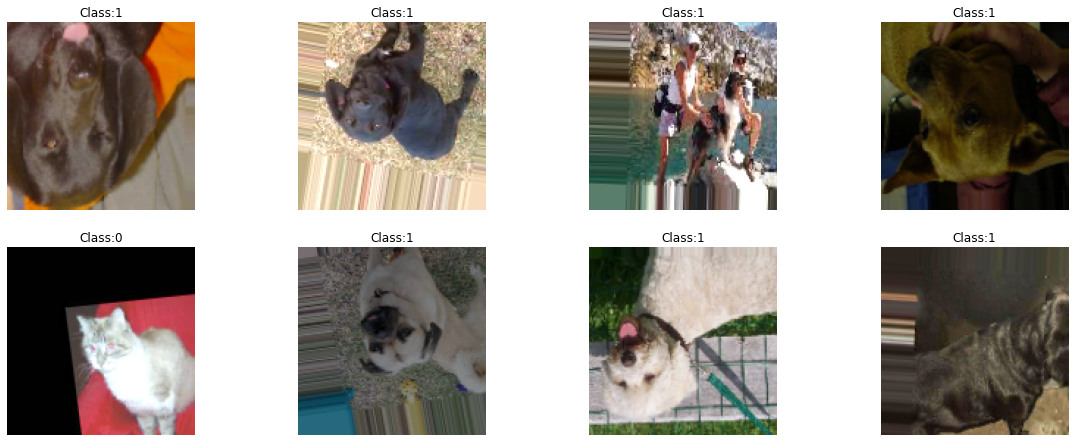

In [32]:
n_samples = 8

plt.figure(figsize=(20,20))
for x_gens, y_gens in train_gen:
#     the first dimension of x_gens and y_gens will be equal to batch_size specifed previously
    print(x_gens.shape)
    i = 0
    for sample_img, sample_class in zip(x_gens, y_gens):
        
        plt.subplot(5,4,i+1)
        plt.title(f'Class:{np.argmax(sample_class)}')
        plt.axis('off')
        plt.imshow(sample_img)
        
        i += 1
        
        if i >= n_samples:
            break
    break

In [33]:
valid_gen = ImageDataGenerator(rescale=1./255)
valid_gen = valid_gen.flow_from_dataframe( valid_df, 
                                           directory = train_images_dir,
                                           x_col='file',
                                           y_col='label',
                                           target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                           class_mode='categorical',
                                           batch_size=BATCH_SIZE)

Found 3750 validated image filenames belonging to 2 classes.


In [40]:
from tensorflow import keras
def myModel(input_shape):
    
    X_input = keras.layers.Input(shape=input_shape, name='input')
    
#     128x128x3
    
    X = keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', name='conv-1')(X_input)    
    X = keras.layers.BatchNormalization(name='b1')(X)
    X = keras.layers.Activation('relu')(X)
    X = keras.layers.MaxPool2D(pool_size=(2,2))(X)
    X = keras.layers.Dropout(0.2)(X)
    
#     64x64x32
    
    X = keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', name='conv-2')(X)    
    X = keras.layers.BatchNormalization(name='b2')(X)
    X = keras.layers.Activation('relu')(X)
    X = keras.layers.MaxPool2D(pool_size=(2,2))(X)
    X = keras.layers.Dropout(0.2)(X)
#     32x32x64

    X = keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', name='conv-3')(X)    
    X = keras.layers.BatchNormalization(name='b3')(X)
    X = keras.layers.Activation('relu')(X)
    X = keras.layers.MaxPool2D(pool_size=(2,2))(X)
    X = keras.layers.Dropout(0.2)(X)
        
#     8x8x128
    
    X = keras.layers.Flatten()(X)
    X = keras.layers.Dense(units=512, name='fc-6')(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.Activation('relu')(X)
    X = keras.layers.Dropout(0.3)(X)
    
    X = keras.layers.Dense(units=2, activation='softmax', name='output')(X)
    
    model = keras.Model(inputs = X_input, outputs = X, name='My_CNN_Model')
    
    return model

In [41]:
model = myModel((IMAGE_SIZE,IMAGE_SIZE,3))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "My_CNN_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv-1 (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
b1 (BatchNormalization)      (None, 128, 128, 32)      128       
_________________________________________________________________
activation_6 (Activation)    (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv-2 (Conv2D)              (None, 64, 64, 64)       

# Training model

In [42]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [43]:
# To stop the training after N epochs and val_loss value not decreased
earlystop = EarlyStopping(patience=2)
# To reduce the learning rate when the accuracy not increase for 5 steps
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

In [44]:
# callbacks = [earlystop, learning_rate_reduction]
callbacks = [earlystop]

In [46]:
 
epochs = 5
history = model.fit(train_gen, 
                    steps_per_epoch = len(train_df)//BATCH_SIZE, 
                    epochs = epochs, 
                    validation_data = valid_gen, 
                    validation_steps = len(valid_df)//BATCH_SIZE)

Epoch 1/5
664/664 [==============================] - 1083s 2s/step - loss: 0.6264 - accuracy: 0.6525 - val_loss: 1.4002 - val_accuracy: 0.5374
Epoch 2/5
664/664 [==============================] - 1085s 2s/step - loss: 0.6046 - accuracy: 0.6661 - val_loss: 0.5491 - val_accuracy: 0.7252
Epoch 3/5
664/664 [==============================] - 1111s 2s/step - loss: 0.5645 - accuracy: 0.7035 - val_loss: 0.5631 - val_accuracy: 0.7270
Epoch 4/5
664/664 [==============================] - 1111s 2s/step - loss: 0.5603 - accuracy: 0.7112 - val_loss: 0.5786 - val_accuracy: 0.7137
Epoch 5/5
664/664 [==============================] - 1101s 2s/step - loss: 0.5422 - accuracy: 0.7238 - val_loss: 1.1554 - val_accuracy: 0.5943


In [47]:
# Saving the weights
model.save_weights('/content/drive/MyDrive/datasets/weights.h5')

# Evaluation of the model

In [48]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [49]:
print("Accuracy = ", history.history['accuracy'][-1])
print("Val. Accuracy = ", history.history['val_accuracy'][-1])

Accuracy =  0.7237722873687744
Val. Accuracy =  0.594284176826477


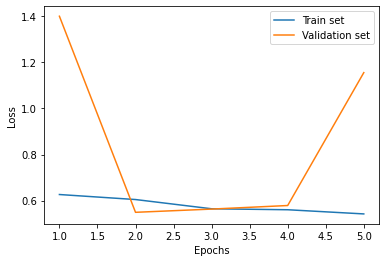

In [50]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)

plt.plot(epochs, loss, label='Train set')
plt.plot(epochs, val_loss, label='Validation set')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

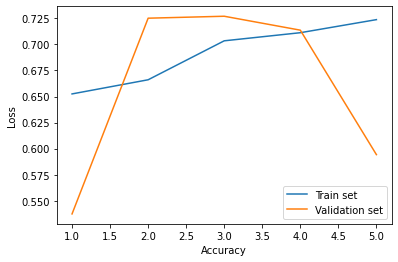

In [51]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1,len(loss)+1)

plt.plot(epochs, accuracy, label='Train set')
plt.plot(epochs, val_accuracy, label='Validation set')

plt.legend()
plt.xlabel('Accuracy')
plt.ylabel('Loss')
plt.show()

# Prediction from test subset

In [52]:
test_images_path = os.listdir(test_images_dir)
test_df = pd.DataFrame({'file':test_images_path})
test_df.head()

,file
0,1.jpg
1,10.jpg
2,100.jpg
3,1000.jpg
4,10000.jpg


In [53]:
test_gen = ImageDataGenerator(rescale=1.0/255.0)
test_gen = test_gen.flow_from_dataframe(test_df, 
                                        directory=test_images_dir, 
                                        x_col='file', 
                                        y_col=None,
                                        class_mode=None,
                                        target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                        color_mode="rgb",
                                        shuffle = False)

Found 12500 validated image filenames.


In [54]:
predictions = model.predict(test_gen)

In [55]:
predictions = np.argmax(predictions,axis=1)
predictions.shape

(12500,)

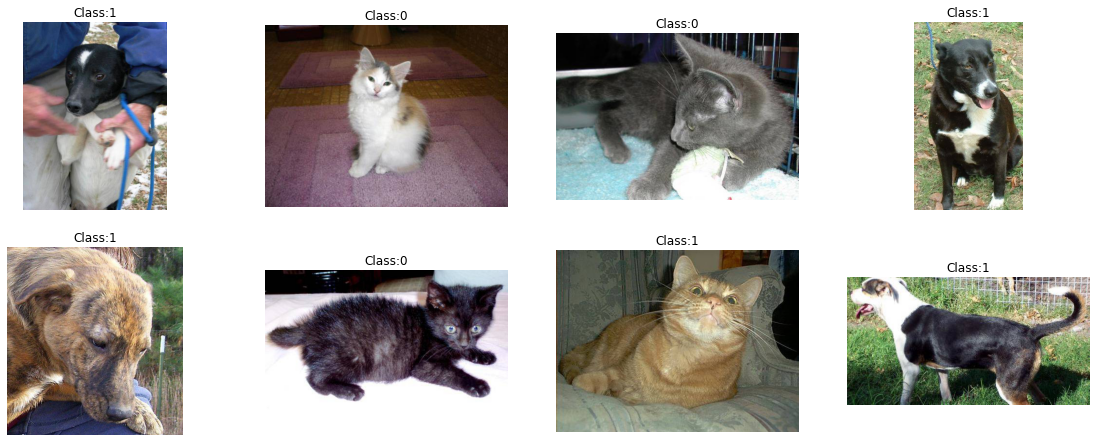

In [58]:
nsamples = 8

plt.figure(figsize=(20,20))
for i, file in enumerate(test_df['file'][:nsamples]):
    img = Image.open(test_images_dir+"/"+file)
    
    plt.subplot(5,4, i+1)
    plt.imshow(img)
    plt.title(f"Class:{predictions[i]}")
    plt.axis('off')

# Submission

In [59]:
submit_df = pd.DataFrame()
submit_df['id'] = range(1,len(predictions)+1)
submit_df['label'] = predictions

submit_df.to_csv('/content/drive/MyDrive/datasets/submission.csv', index=False)

submit_df.head(10)

,id,label
0,1,1
1,2,0
2,3,0
3,4,1
4,5,1
5,6,0
6,7,1
7,8,1
8,9,1
9,10,1
